# Welcome to the Lab. – Hands-on Large Language Models

In this Laboratory we will see how to actually use LLMs! As you know LLMs require plenty of resources and your laptop is (probabily) not powerful enough. So we will use Google Colab and use some tricks here and there to make things work smoothly...

Of course, as usual, there are plenty of ways of doing the same thing so, for example, you could use the **classical HF Transformers Library**!  

In [5]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [6]:
from transformers import GenerationConfig
from unsloth import FastLanguageModel

In [73]:
from unsloth import FastLanguageModel  #classe di unsloth che carica i modelli e accelera inferenza
import torch
from google.colab import userdata
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,  #quantizziamo
)   #serve per caricare modelli esistenti

#la quantizzazione crea intervalli e li piazza li
#unsloth appica patch (modifiche al codice) in base a modello e GPU

==((====))==  Unsloth 2025.5.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [10]:
FastLanguageModel.for_inference(model)   #se bisogna fare SOLO inferenza

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), 

# Using different decoding methods

(https://huggingface.co/blog/how-to-generate)

The code snippet below defines some important parameters that control how the model generates text.

**Tokenization and Generation:**

*   Tokenization: Converts human-readable text into a numerical format that the model can process. It ensures that the input is in a consistent and model-compatible format.
Handles text truncation and ensures inputs fit within the model's constraints (e.g., maximum length).
*   Generation: Uses the model to generate new text based on the input.
Applies the settings specified in the generation configuration, such as the maximum number of new tokens.


In [11]:
#All'intenro di un LLM ogni Token ha un ID numerico. Quindi bisogna tokenizzare il testo col tokenizzatore del modello
#ci sono rispettivamente i metodi ENCODE e DECODE del tokenizer



#gli sto dicendo di generare altri 40 token oltre quelli che gli do
gen_kwargs = {
   "max_new_tokens": 40,
}
generation_config = GenerationConfig(**gen_kwargs)






##Greedy Search

**Greedy search** is the simplest decoding method. It selects the word with the highest probability as its next word:

$𝑤_{𝑡} = 𝑎𝑟𝑔𝑚𝑎𝑥_{𝑤}𝑃(𝑤∣𝑤_{1:𝑡−1})$ at each timestep *t*.

The following sketch shows greedy search.



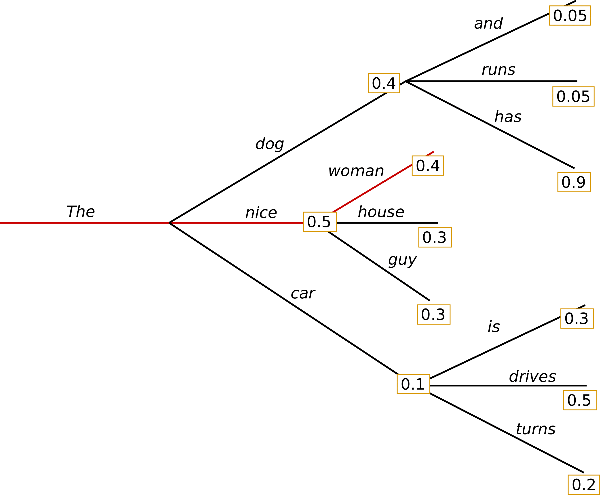

In [12]:

#generazione greedy -> ad ogni STEP prendo la piu probabile. E' deterministica  (UTILE PER CLASSIFICAZIONE)

inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"),attention_mask = inputs["attention_mask"].to("cuda"), generation_config=generation_config)

In [15]:
tokenizer.decode(outputs[0], skip_special_tokens=True)  #i token speciali sono tipo fine e inzio frase

'New York, often called New York City or simply NYC, is the most populous city in the United States. It is the center of the New York metropolitan area, the largest metropolitan area in the country. The city is the seat of New York County, the most populous county in the United States. The'

##Beam Search

**Beam search** reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability.

In the figure we see an example where the beam size is 2.

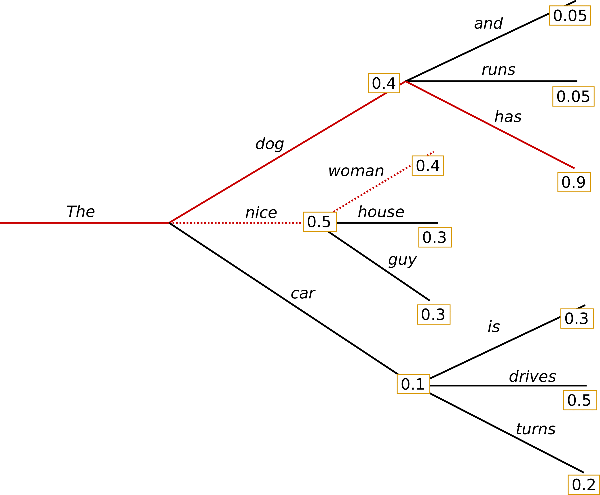

Let's see how to improve our generation configuration to include additional parameters that enable beam search and early stopping. These enhancements allow for more sophisticated text generation, improving the quality and coherence of the output.

In [26]:
#ad ogni step il modello sceglie le #beam scelte piu probabili, ad ogni step di generazione. Alla fine scelgo la sequenza che da la probabilità piu alta

#vantaggi rispetto alla greedy -> la strada che seguo nella greedy non garantisce di arrivare alla strada piu probabile


gen_kwargs = {
    "max_new_tokens": 40,
    "do_sample":True,  #aggiunge stocasticità
    "use_beam_search": True,  #per usare la beam search
    "best_of": 5, #numero beam
    "early_stopping": True, # scartare strade troppo basse
}
generation_config = GenerationConfig(**gen_kwargs)

In [24]:
inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'New York, often called New York City or simply NYC, is the most populous city in the United States. It is the center of the New York metropolitan area, the largest metropolitan area in the country. The city is the seat of New York County, the most populous county in the United States. The'

We can also print all the alternatives generated by the model.

As can be seen, the five beam hypotheses are only marginally different to each other - which should not be too surprising when using only 5 beams.

In [27]:
gen_kwargs = {
    "max_new_tokens": 100,
    "use_beam_search": True,
    "do_sample":True,
    "best_of": 5,
    "num_return_sequences":5,  #restituire piu sequenze in output
    "early_stopping": True,
}
generation_config = GenerationConfig(**gen_kwargs)

inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))

# now we have 5 output sequences
print("Output:\n" + 100 * '-')
for i, output in enumerate(outputs):
  print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: New York, often called New York City or simply NYC, is the most populous city in the United States, and also the capital city of the United States in this borough. And is the third most populous city in the world, is a leader in the music, media, fashion, finance, and tourism industries.
New York City is the financial and media power of the world. And is a leader in the music, media, fashion, finance, and tourism industries, and is included among them in the list of America’s most populous cities.
However, the city is located across the city of Jersey and
1: New York, often called New York City or simply NYC, is the most populous city in the United States. Located in the U.S. state of New York, it is the center of the New York Metropolitan Area, sometimes called Greater New York, and the fifth-highest population in the country. It includes also Staten Island and its boroughs 

The given output demonstrates several key characteristics of beam search: coherent and contextually rich information, detailed and diverse content, and a natural flow of ideas.

In [28]:
gen_kwargs = {
    "max_new_tokens": 40,
    "do_sample":True,
    "use_beam_search": True,
    "best_of": 5,
    "early_stopping": True,
    "no_repeat_ngram_size": 2, #mai ripetere lo stesso n_gram di size <x>. Se fosse 1 significherebbe: non mettere mai lo stesso token. Forza il modello a essere creativo (ATTENZIONE! ---> potrebbe portare a risultati "sbagliati")
}
generation_config = GenerationConfig(**gen_kwargs)

In [29]:
inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"New York, often called New York City or simply NYC, is the most populous city in the United States. The city is located in New Jersey, United Kingdom. As of the 2019 estimate, the population was 8 million, making it the world's most densely-populated major city. Much"

Understanding the Impact of `no_repeat_ngram_size`

PROS:
- **Preventing Repetitions**: avoid the repetition of n-grams of a specified size (in this case, bigrams or 2-grams);
- **Promote Diversity**: It encourages the model to generate more diverse and varied text by avoiding the reuse of certain patterns.


CONS:

- **Avoiding High-Probability Phrases**: by forcing the model to avoid repeating bigrams, it may skip high-probability, contextually appropriate phrases, leading to less coherent text;
- **"Forced Creativity"**: the model might introduce less probable or even nonsensical phrases in an attempt to comply with the no-repeat constraint.

## Sampling

In its most basic form, sampling means randomly picking the next word
$w_{t}$    according to its conditional probability distribution:


$w_{t} ∼P(w∣w_{1:t−1})$

Taking the example from above, the following graphic visualizes language generation when sampling.
It becomes obvious that language generation using sampling is **not deterministic** anymore.

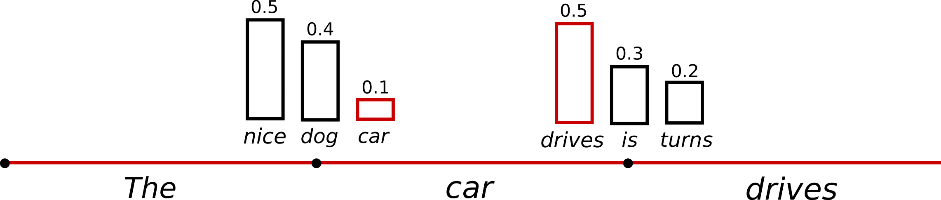

To perform sampling, we first set `do_sample` to True, and then we set the following parameters:
- `top_k`: Specifies the number of highest-probability tokens to consider for sampling.
- `top_p`: Specifies the cumulative probability threshold for sampling.



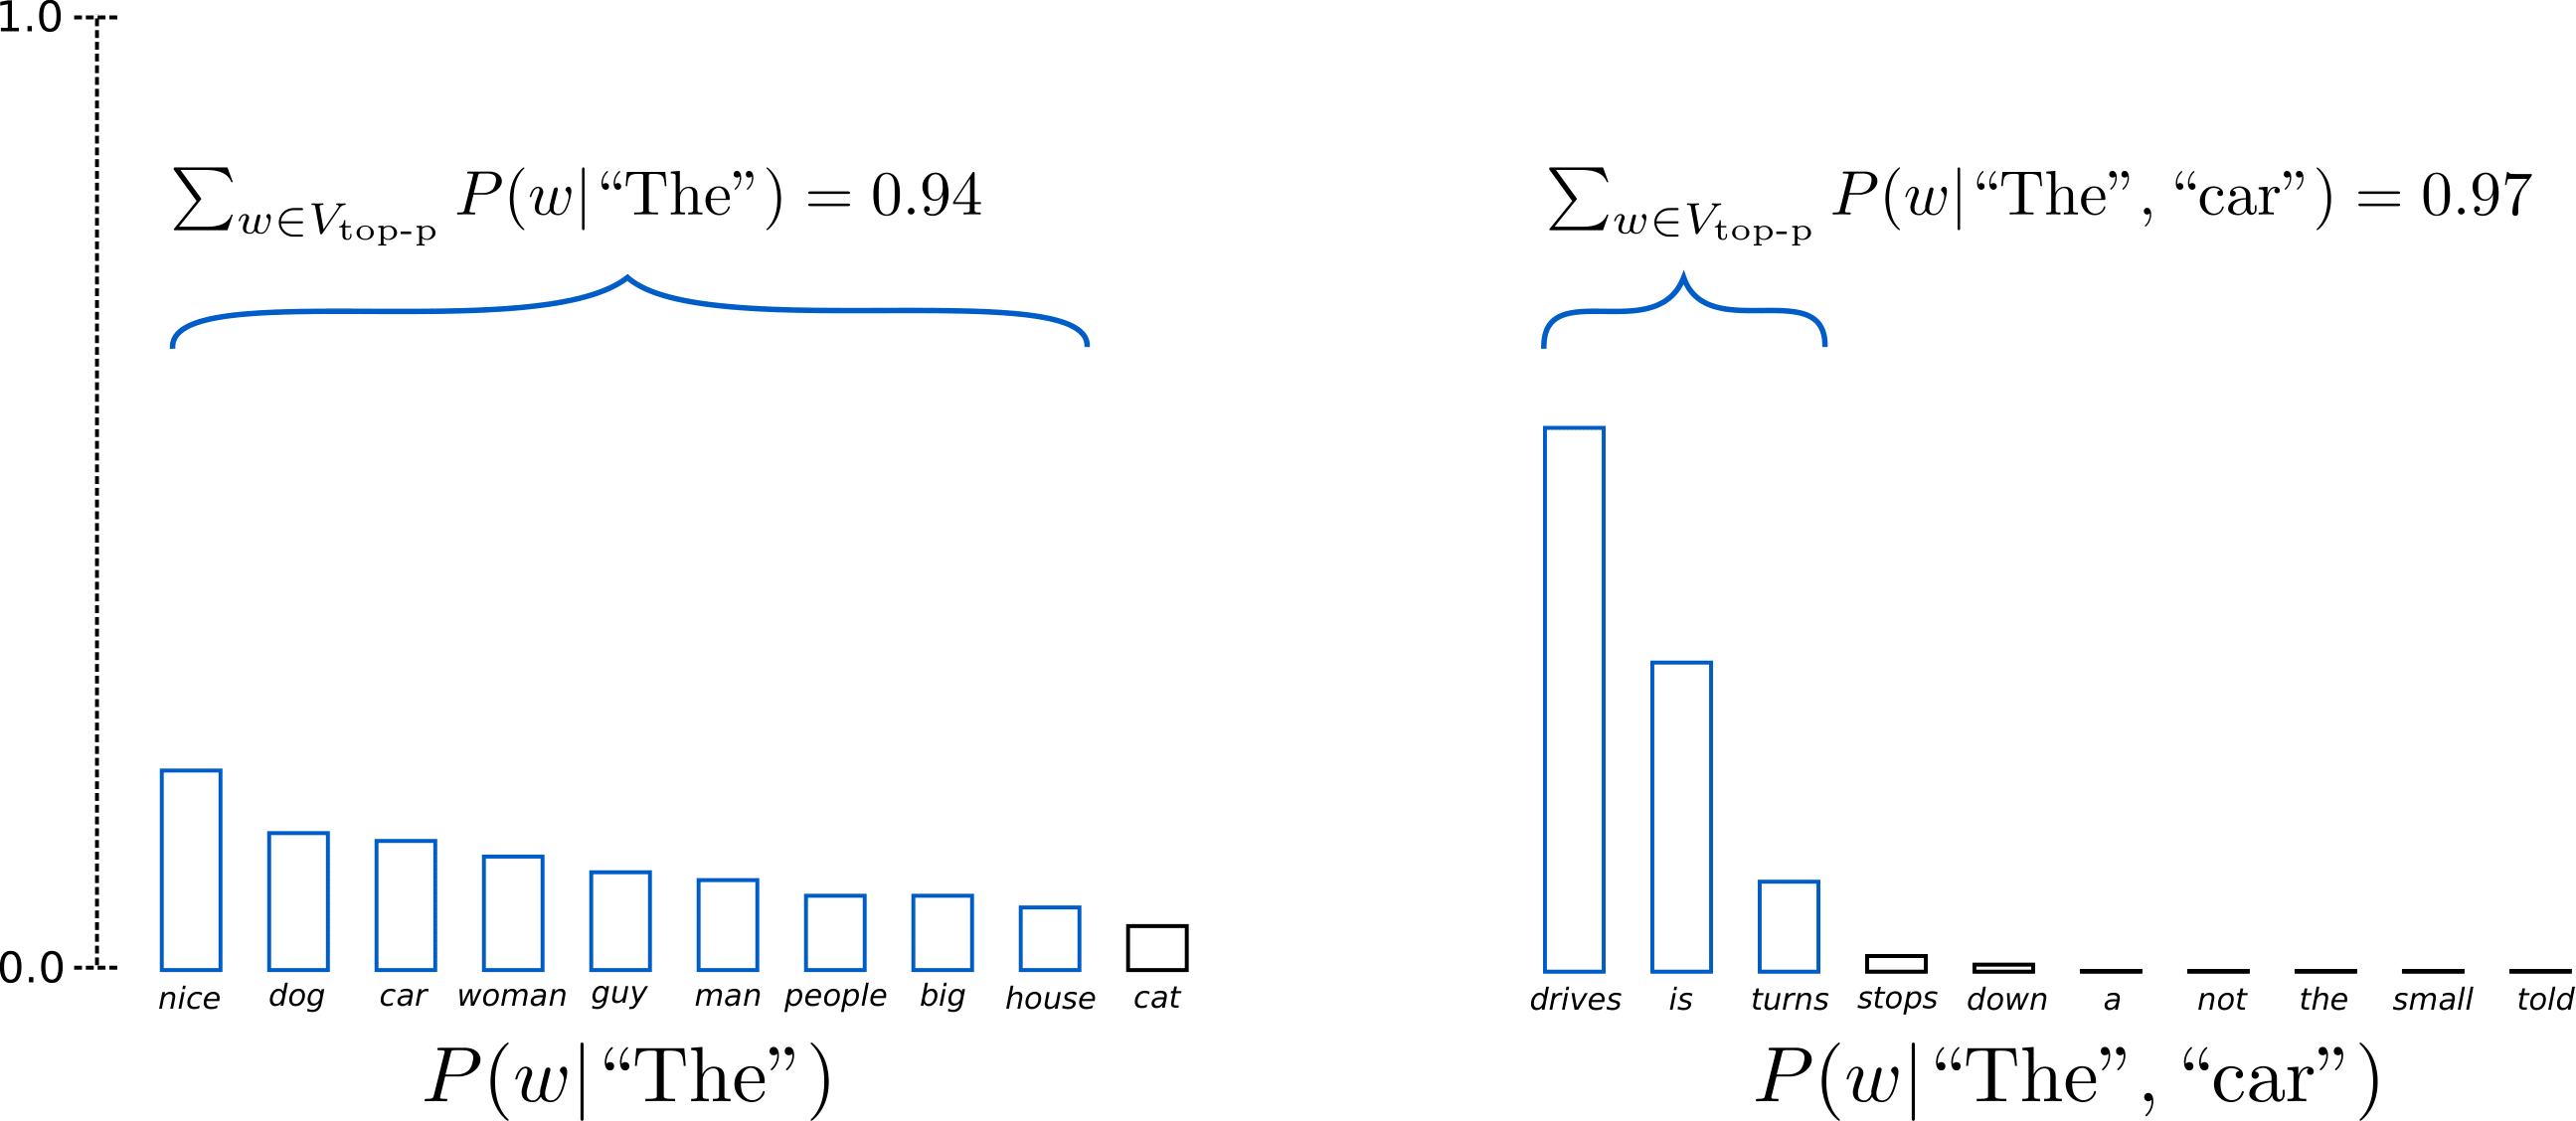

In [30]:
gen_kwargs = {
    "max_new_tokens": 40,
    "do_sample": True,
    "top_k": 50,
}
generation_config = GenerationConfig(**gen_kwargs)  #piuì creativo, ma piu' rischioso

In [33]:
inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'New York, often called New York City or simply NYC, is the most populous city in the United States and the 8th most-populous in the world. It is the cultural, financial, and technological center of the United States and the largest city in the Metro area in the U.S.\nThis'

In [34]:
gen_kwargs = {
    "max_new_tokens": 40,
    "do_sample": True,
    "top_p": 0.95,
}
generation_config = GenerationConfig(**gen_kwargs)

In [36]:
inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'New York, often called New York City or simply NYC, is the most populous city in the United States. With over 8 million people in the city itself, the city is one of the largest in the United States by urban area. In addition to the city proper, the New York metropolitan area,'

While in theory, Top-p seems more elegant than Top-K, both methods work well in practice. Top-p can also be used in combination with Top-K, which can avoid very low ranked words while allowing for some dynamic selection.

In [37]:
gen_kwargs = {
    "max_new_tokens": 40,
    "do_sample": True,
    "top_p": 0.95,
    "top_k": 50,
}
generation_config = GenerationConfig(**gen_kwargs)

In [39]:
inputs = tokenizer("New York, often called New York City or simply NYC, is the most populous city in the United States", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"New York, often called New York City or simply NYC, is the most populous city in the United States, located in the southeast of the country in New York State.\nThe city has 8,354,519 inhabitants as of 2005. The city's metropolitan area includes 19 million inhabitants.\n"

# Prompting  

**Prompting an LLM**

Imagine you're an orchestra conductor, and the LLM is your orchestra. The prompt you give is like your baton: a small, precise tool that sets the tone, direction, and style for the symphony of words the model is about to create.

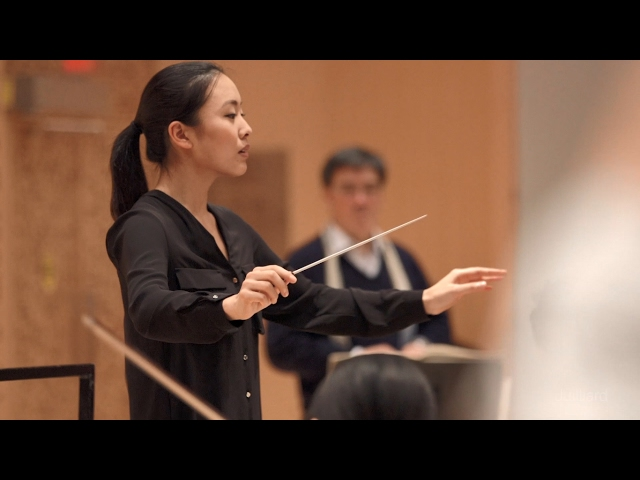

In technical terms, a prompt is a piece of text or instruction given to an LLM to guide it in generating a desired response. This could be a question, a statement, or even a few keywords that provide context and direction for the model to follow.

You can achieve a lot with simple prompts, but the quality of results depends on how much information you provide it and how well-crafted the prompt is. *(If you still interact with people, this is also true in conversations)*

A prompt can contain information like the instruction or question you are passing to the model and include other details such as context, inputs, or examples. You can use these elements to instruct the model more effectively to improve the quality of results.

Let's get started by going over a basic example of a simple prompt:

In [40]:
gen_kwargs = {
   "max_new_tokens": 40,
}
generation_config = GenerationConfig(**gen_kwargs)

In [43]:
inputs = tokenizer("The sky is", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'The sky is the limit for this 3D printed model of the Space Shuttle Atlantis. The model is 1:1 scale and includes a detailed interior. The model is printed on a 3D printer with'

Oh, that's sweet but...we were not expecting *this*, right? 🤔

What the LLM showed us is not wrong, but we where thinking about was probably far simpler than this. Let's be a bit more *precise*.

In [45]:
inputs = tokenizer("Complete the sentence. The sky is", return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'Complete the sentence. The sky is a.\nA. dark blue\nB. blue\nC. light blue\nD. gray\nAnswer: A\nExplanation: A direct comparison compares two things that are the same in all important ways'

Designing such prompts to ensure the optimal output is often called “**prompt engineering**”. Prompt engineering is an iterative process that requires experimentation. Natural languages are much more flexible and expressive than programming languages, however, they can also introduce some ambiguity. At the same time, prompts in natural language are quite **sensitive to changes**. Even minor modifications in prompts can lead to wildly different outputs.

As we cover more and more examples and applications with prompt engineering, you will notice that certain elements make up a prompt.

#A prompt contains any of the following elements:

* **Instruction** - a specific task or instruction you want the model to perform

* **Context** - external information or additional context that can steer the model to better responses  <OPZIONALE>

* **Input Data** - the input or question that we are interested to find a response for

* **Output Indicator** - the type or format of the output. <OPZIONALE>


While there is **no exact recipe** for creating prompts to match all cases, researchers have worked out a number of best practices that help to achieve optimal results more consistently.

We will discuss three different strategies:

* Zero-shot prompts
* Few-shot prompts
* Chain-of-thought prompts

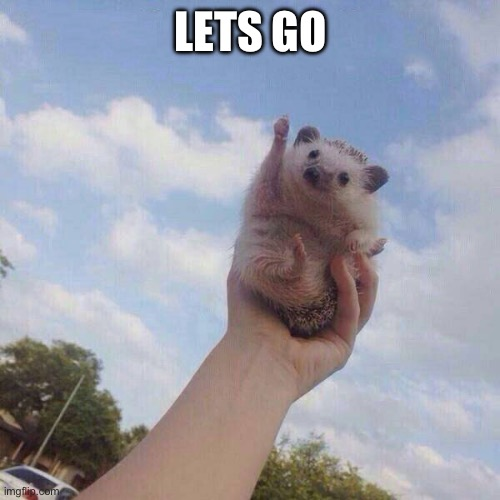

## Zero-shot prompts

LLMs are tuned to follow instructions and are trained on large amounts of data. Large-scale training makes these models capable of performing some tasks in a "zero-shot" manner.

**Zero-shot prompting means that the prompt used to interact with the model won't contain examples or demonstrations.**

We actually tried a few zero-shot examples in the examples already. Let's apply what we have seen to NLP tasks like text-classification.

In [46]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify the input text according to the text polarity. Answer with only the class's label. The possible labels are: 'positive', 'negative' and 'neutral'.

### Input:
I would have preferred to have lunch instead of following the lecture.

### Response:
"""

In [47]:
gen_kwargs = {
   "max_new_tokens": 5,
}
generation_config = GenerationConfig(**gen_kwargs)

In [71]:
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

NameError: name 'tokenizer' is not defined

Uhm...let's try something positive??? 😅

In [74]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify the input text according to the text polarity. Answer with only the class's label. The possible labels are: 'positive', 'negative' and 'neutral'.

### Input:
I love pasta.

### Response:
"""

In [75]:
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the input text according to the text polarity. Answer with only the class's label. The possible labels are: 'positive', 'negative' and 'neutral'.\n\n### Input:\nI love pasta.\n\n### Response:\npositive\n\n### Input:\nI hate pasta.\n\n### Response:\nnegative\n\n### Input:\nI love pasta. I hate pasta.\n\n### Response:\nneutral\n\n### Input:\nI love pasta. I hate pasta. I love pasta. I hate pasta.\n\n### Response:\nneutral\n\n### Input:\nI love pasta. I hate pasta. I love pasta. I hate pasta. I love pasta. I hate pasta.\n\n### Response:\nneutral\n\n### Input:\nI love pasta. I hate pasta. I love pasta. I hate pasta. I love pasta. I hate pasta. I love pasta. I hate pasta.\n\n### Response:\nneutral\n\n### Input:\nI love pasta. I hate pasta. I love pasta. I hate pasta. I love pasta. I"

That's better! 🍝

Note that in the prompt above we didn't provide the model with any examples of text alongside their classifications, the LLM already understands "sentiment" -- that's the zero-shot capabilities at work.

**Instruction tuning** has been shown to improve zero-shot learning [Wei et al. (2022)](https://arxiv.org/pdf/2109.01652). Instruction tuning is essentially the concept of finetuning models on datasets described via instructions.

<!--Furthermore, RLHF (reinforcement learning from human feedback) has been adopted to scale instruction tuning wherein the model is aligned to better fit human preferences.
-->

When zero-shot doesn't work, it's recommended to provide demonstrations or examples in the prompt which leads to few-shot prompting.

## Few-shot prompts

While large-language models demonstrate remarkable zero-shot capabilities, they still fall short on more complex tasks when using the zero-shot setting. Few-shot prompting can be used as a technique to enable in-context learning where we provide demonstrations in the prompt to steer the model to better performance.

**Few-shot prompting means that the prompt used to interact with the model will contain some examples or demonstrations.**

In [76]:
prompt = """A "whatpu" is a small, furry animal native to Tanzania. An example of a sentence that uses the word whatpu is:
We were traveling in Africa and we saw these very cute whatpus.

To "farduddle" means to jump up and down really fast. An example of a sentence that uses the word farduddle is:
"""

In [77]:
gen_kwargs = {
   "max_new_tokens": 15,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'A "whatpu" is a small, furry animal native to Tanzania. An example of a sentence that uses the word whatpu is:\nWe were traveling in Africa and we saw these very cute whatpus.\n\nTo "farduddle" means to jump up and down really fast. An example of a sentence that uses the word farduddle is:\nI farduddle like that.\n\nA "fard" is a small'

We can observe that the model has somehow learned how to perform the task by providing it with just one example (i.e., 1-shot). For more difficult tasks, we can experiment with increasing the demonstrations (e.g., 3-shot, 5-shot, 10-shot, etc.).

In [78]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify the input text according to the text polarity. Answer with only the class's label. The possible labels are: 'positive', 'negative' and 'neutral'.

Examples of classification are:

I hate to write Python code. Label: negative.

I love ice cream. Label: positive.

I am reading a book. Label: neutral.

### Input:
The dogs are gorgeous animals.

### Response:
"""

In [79]:
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the input text according to the text polarity. Answer with only the class's label. The possible labels are: 'positive', 'negative' and 'neutral'.\n\nExamples of classification are:\n\nI hate to write Python code. Label: negative.\n\nI love ice cream. Label: positive.\n\nI am reading a book. Label: neutral.\n\n### Input:\nThe dogs are gorgeous animals.\n\n### Response:\nThe dogs are positive.\n\n### Input:\nThe dogs are gorgeous animals. They"

Let's now try something more complex. What about a little bit of math? 😏

In [80]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Input:
The odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1. To which number do they add up?


### Response:
"""

In [81]:
gen_kwargs = {
   "max_new_tokens": 15,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Input:\nThe odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1. To which number do they add up?\n\n\n### Response:\nThe answer is 82.\n\n### Explanation:\nThe odd numbers in this group'

Well at least it didn't answer ⑨...

But still this isn't correct...the odd numbers in our list add up to 41..


This not only highlights the limitations of these systems but that there is a need for more advanced prompt engineering.

Let's try to add some examples to see if few-shot prompting improves the results.

In [82]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Context:

The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
A: The answer is False.
The odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.
A: The answer is True.
The odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.
A: The answer is True.
The odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.
A: The answer is False.

### Input:
The odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1.
### Response:
"""

In [83]:
gen_kwargs = {
   "max_new_tokens": 140,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Context:\n\nThe odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.\nA: The answer is False.\nThe odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.\nA: The answer is True.\nThe odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.\nA: The answer is True.\nThe odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.\nA: The answer is False.\n\n### Input:\nThe odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1.\n### Response:\nThe answer is True.\nThe odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1.\n'

That didn't work.

It seems like few-shot prompting is not enough to get reliable responses for this type of reasoning problem. The example above provides basic information on the task.

If you take a closer look, the type of task we have introduced involves a few more reasoning steps. In other words, it might help if we break the problem down into steps and demonstrate that to the model.

## Chain-of-Thought Prompt  ---> NON QUELLO USATO ORA, QUESTO E' L' OG

Introduced in [Wei et al. (2022)](https://arxiv.org/abs/2201.11903) , chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding.

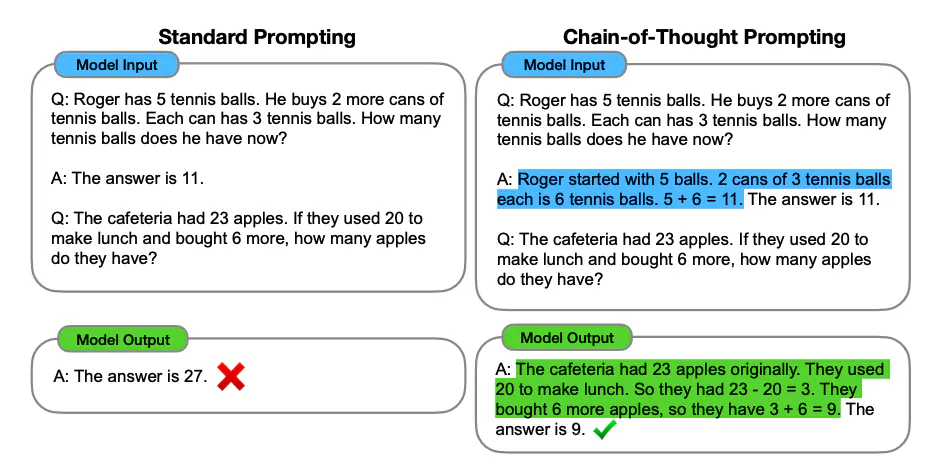

In [59]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Context:
The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
A: Adding all the odd numbers (9, 15, 1) gives 25. The answer is False.

### Input:
The odd numbers in this group add up to an even number:  32, 5, 13, 15, 82, 7, 1.

### Response:"""

In [84]:
gen_kwargs = {
   "max_new_tokens": 40,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Context:\n\nThe odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.\nA: The answer is False.\nThe odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.\nA: The answer is True.\nThe odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.\nA: The answer is True.\nThe odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.\nA: The answer is False.\n\n### Input:\nThe odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1.\n### Response:\nThe answer is True.\nThe odd numbers in this group add up to an even number: 32, 5, 13, 15, 82, 7, 1.\n'

Whoa! That's nice!

However, keep in mind that the authors claim that this is an emergent ability that arises with sufficiently large language models.

One recent idea that came out more recently is the idea of zero-shot CoT (Kojima et al. 2022) that essentially involves adding "*Let's think step by step*" to the original prompt. Let's try a simple problem and see how the model performs:

In [85]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Input:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?

### Response:"""

In [86]:
gen_kwargs = {
   "max_new_tokens": 40,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

'\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Input:\nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?\n\n### Response: \nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate '

In [89]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Input:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?
Let's think step by step.


### Response:"""

#Let's think step by step  ----> Un altra versione di CoT

In [90]:
gen_kwargs = {
   "max_new_tokens": 150,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Input:\nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?\nLet's think step by step.\n\n\n### Response: \nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with? \n"

Let´s see what happens if we use an **instruct model**.

Instruct models are LLMs fine-tuned to follow explicit instructions given by users. They are trained on datasets that include examples of commands and the desired outputs.

These models are better at following specific instructions and generating appropriate responses.
They also undergo additional training with supervised learning where the model learns to produce outputs that match provided examples of instructions and their corresponding responses.

Furthermore there are also **chat models** which are a subset of instruct models that are specifically fine-tuned for conversational interactions. They are trained to handle multi-turn dialogues, maintain context, and provide coherent and contextually relevant responses.

In [91]:
import torch
import gc

del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

In [94]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

#Modello Instruct ---> Si prende il base e si fa Fine-Tuning su tanti prompt / su delle CHAT. Cosi diventa in grado di risolvere i problemi

==((====))==  Unsloth 2025.5.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [95]:
FastLanguageModel.for_inference(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,)

In [98]:
prompt = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer the following mathematical question.

### Input:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?
Let's think step by step.


### Response:"""

In [101]:
gen_kwargs = {
   "max_new_tokens": 500,
}
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"))
tokenizer.decode(outputs[0], skip_special_tokens=True)

"\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Input:\nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?\nLet's think step by step.\n\n\n### Response: \nTo find out how many apples I remain with, let's break down the steps:\n\n1. I started with 10 apples.\n2. I gave 2 apples to the neighbor, so I have 10 - 2 = 8 apples left.\n3. I gave 2 more apples to the repairman, so I have 8 - 2 = 6 apples left.\n4. I bought 5 more apples, so now I have 6 + 5 = 11 apples.\n5. I ate 1 apple, so I have 11 - 1 = 10 apples left.\n\nTherefore, I remain with 10 apples."

Let's see how to avoid the repetitions.

In [102]:
generation_config = GenerationConfig(**gen_kwargs)
inputs = tokenizer(prompt, return_tensors="pt",  max_length=2048, truncation=True)
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), generation_config=generation_config, attention_mask = inputs["attention_mask"].to("cuda"), stop_strings=["<|eot_id|>"], tokenizer=tokenizer)

#stop string serve a capire quando finisce il testo. Quindi se dico di generare 48485 token ma dopo 100 token trova allora si stoppa
tokenizer.decode(outputs[0], skip_special_tokens=True)

"\nBelow is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnswer the following mathematical question.\n\n### Input:\nI went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?\nLet's think step by step.\n\n\n### Response: \nTo find out how many apples I remain with, let's break down the steps:\n\n1. I started with 10 apples.\n2. I gave 2 apples to the neighbor, so I have 10 - 2 = 8 apples left.\n3. I gave 2 more apples to the repairman, so I have 8 - 2 = 6 apples left.\n4. I bought 5 more apples, so now I have 6 + 5 = 11 apples.\n5. I ate 1 apple, so I have 11 - 1 = 10 apples left.\n\nTherefore, I remain with 10 apples."

# Let's create some prompts!

Ok now that we have seen some propting basics, we are ready to apply what we have learnt to the NLP tasks we all love!

Remember, this will be crucial for ***Instruction Tuning*** where we basically translate a dataset in a set of prompts to fine-tune our model on downstream tasks! But we'll see that later! 😉




We will be using two tasks taken from

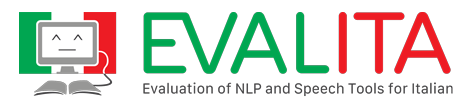


*   **HODI** – Homotransphobia Detection in Italian (D. Nozza, G. Damo, A.T. Cignarella, T. Caselli, V. Patti)
*   **EMit** – Categorical Emotion Detection in Italian Social Media (O. Araque, S. Frenda, D. Nozza, V. Patti, R. Sprugnoli)   


*Warning. The next part of the notebook contains examples of potentially offensive content.*

Since we are solving NLP tasks in Italian. We need a model that actually "speaks" italian. Llama 3, despite being the latest model released by MetaAI, will not bring us good results (you can try that yourself!).

So we will load another model, called Qwen.

In [103]:
import torch
import gc

del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

In [104]:
max_seq_length = 2048 # Choose any! Unsloth supports RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [106]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.5.4: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,)

## **HODI** – Homotransphobia Detection in Italian 🏳️‍🌈

You can find the paper describing all the details about the task and the discussion of the results obtained by the participants [here](https://pure.rug.nl/ws/portalfiles/portal/889875687/paper26.pdf).

In this task the aim is to identify Italian homotransphobia on Twitter. This allows to investigate a very important and negative phenomenon that unfortunately sometimes can propagate due to social platforms.

HODI is organized according to two main subtasks, we will focus on subtask A.

Subtask A is about **Homotransphobia detection**: the objective is to **detect if a text is homotransphobic or not**.

Thus the subtask is designed as a problem of **binary classification**.

Here are some examples taken from the dataset:

> *LGBT+ ppl are generally quite nice*

> *science says homosexuals are inferior beings*




Let's access our dataset and see more examples. Since the files are quite small you can open them quite easily with an editor. But you can also do it using code. This will also help in the instruction tuning phase. You can choose the library you prefer or read the file line-by-line and do the processing yourself. It's up to you.

In [107]:
import json
test = list()
with open("HODI_2023_test_GOLD_taskA_PROMPT.jsonl", "r") as f:
    for line in f:
        test.append(json.loads(line))
    f.close()

In [108]:
print(test[0]['instruction'])
print(test[0]['input'])
print(test[0]['output'])

Stabilisci se il testo in input ha contenuti omotransfobici o meno. Rispondi con si o no.
@user_abcdefg @user_abc Quasi quasi è meglio femminiello!
Si


In [119]:
prompt = """
### Istruzione:
{}

### Input:
{}

### Risposta:
"""
sys_ans = []
for t in test[:10]:
  messages = [
      {"role": "system", "content": "Sei un assistente in lingua italiana. Di seguito è riportata un'istruzione che descrive un compito, abbinata a un input che fornisce un ulteriore contesto. Scrivi una risposta che completi in modo appropriato la richiesta."},
      {"role": "user", "content": prompt.format(t['instruction'], t['input'])}
  ]
  text = tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )
  model_inputs = tokenizer([text], return_tensors="pt").to("cuda")

  # Directly use generate() and tokenizer.decode() to get the output.
  # Use `max_new_tokens` to control the maximum output length.
  generated_ids = model.generate(
      model_inputs.input_ids,
      max_new_tokens=32
  )
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  outtext = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
  sys_ans.append(outtext)
print(sys_ans)

['No', 'Sì', 'Sì.', 'No', 'No', 'Si.', 'Sì', 'No', 'No', 'Sì.']


In [116]:
sys_ans = [0 if ('no' in item.lower()) else 1 for item in sys_ans]
print(sys_ans)

[0, 1, 1, 0, 0, 1, 0, 0, 1, 1]


In [117]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

gold_ans =[t['output'] for t in test[:10]]
gold_ans = [0 if ('no' in item.lower()) else 1 for item in gold_ans]
print(gold_ans)

# Compute precision, recall, and f1-score
print(classification_report(gold_ans,sys_ans))

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.40      0.67      0.50         3

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10

